In [47]:
# Import features and data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from src.feature_utils import log_transform, ordinal_encode, scale_features
from src.model_utils import get_models
from src.validation_utils import run_kfold
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

df = pd.read_csv("Stars.csv")

In [33]:
# Plot Stylization

plt.style.use("dark_background")

COLORS = {
    "pink": "#ff4ecd",
    "blue": "#4ea8ff",
    "green": "#3dff9f",
    "purple": "#b36bff"
}

In [7]:
# Apply features

df_fe = log_transform(
    df,
    columns=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)"]
)

df_fe = ordinal_encode(df_fe)
df_fe.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3.486855,-2.619789,-0.769551,16.12,0,11,6
1,3.483159,-3.301029,-0.811916,16.60,0,11,6
2,3.414973,-3.522877,-0.991400,18.70,0,11,6
3,3.447158,-3.698968,-0.795880,16.65,0,11,6
4,3.287578,-3.860118,-0.987163,20.06,0,11,6


In [9]:
# Seperate Features from the Target

X = df_fe.drop("Star type", axis=1)
y = df_fe["Star type"]

X_scaled, scaler = scale_features(X)

In [25]:
# Instantiate the baseline
models = get_models()

# Evaluate the baseline

results = {}

for name, model in models.items():
    mean_acc, std_acc = run_kfold(
        model=model,
        X=X_scaled,
        y=y,
        k=5
    )
    results[name] = (mean_acc, std_acc)
    print(f"{name}: {mean_acc:.3f} ± {std_acc:.3f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

logistic_regression: 0.975 ± 0.016
knn: 0.983 ± 0.016
random_forest: 1.000 ± 0.000
svm: 0.979 ± 0.019


In [27]:
# Table of results above

pd.DataFrame(
    results,
    index=["Mean Accuracy", "Std Dev"]
).T

,Mean Accuracy,Std Dev
logistic_regression,0.975000,0.015590
knn,0.983333,0.015590
random_forest,1.000000,0.000000
svm,0.979167,0.018634


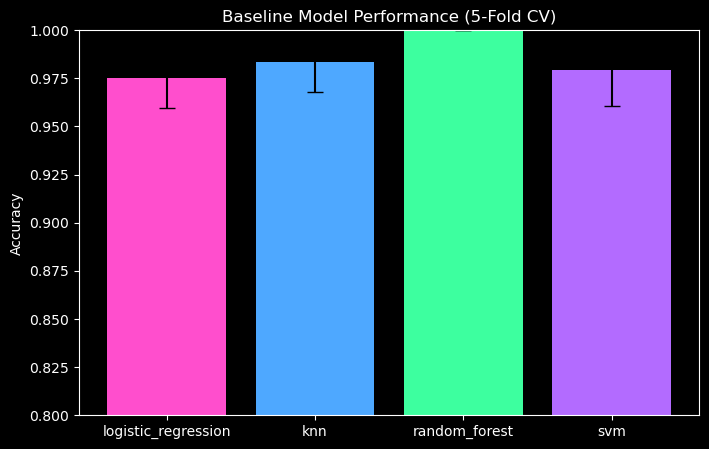

In [35]:
# Mean vs CV

model_names = list(results.keys())
mean_acc = [results[m][0] for m in model_names]
std_acc = [results[m][1] for m in model_names]

plt.figure(figsize=(8, 5))
plt.bar(
    model_names,
    mean_acc,
    yerr=std_acc,
    capsize=6,
    color=[COLORS["pink"], COLORS["blue"], COLORS["green"], COLORS["purple"]]
)

plt.ylabel("Accuracy")
plt.title("Baseline Model Performance (5-Fold CV)")
plt.ylim(0.8, 1.0)
plt.show()

In [37]:
# Create cross validation folds

plt.style.use("dark_background")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
cv_predictions = {}
cv_probabilities = {}

In [39]:
# Clearly seperate the sets

for name, model in models.items():

    y_pred = cross_val_predict(
        model,
        X,
        y,
        cv=cv,
        method="predict"
    )

    y_prob = cross_val_predict(
        model,
        X,
        y,
        cv=cv,
        method="predict_proba"
    )

    cv_predictions[name] = y_pred
    cv_probabilities[name] = y_prob

    results.append({
        "model": name,
        "accuracy": accuracy_score(y, y_pred),
        "roc_auc": roc_auc_score(
            y,
            y_prob,
            multi_class="ovr"
        )
    })

df_results = pd.DataFrame(results)
df_results

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

,model,accuracy,roc_auc
0,logistic_regression,0.995833,0.999938
1,knn,0.995833,1.000000
2,random_forest,1.000000,1.000000
3,svm,0.929167,0.997292


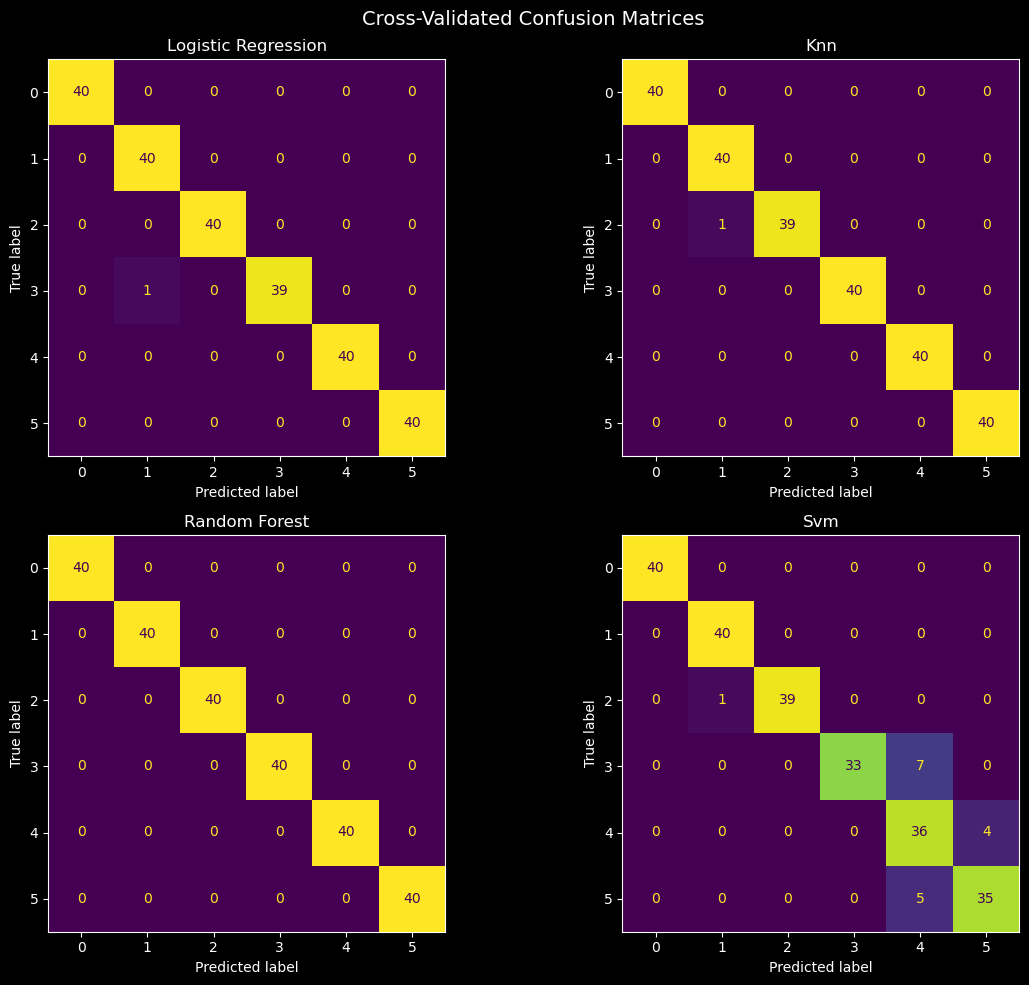

In [41]:
# Confustion Matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, cv_predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y,
        y_pred,
        ax=ax,
        colorbar=False
    )
    ax.set_title(name.replace("_", " ").title())

plt.suptitle("Cross-Validated Confusion Matrices", fontsize=14)
plt.tight_layout()
plt.show()

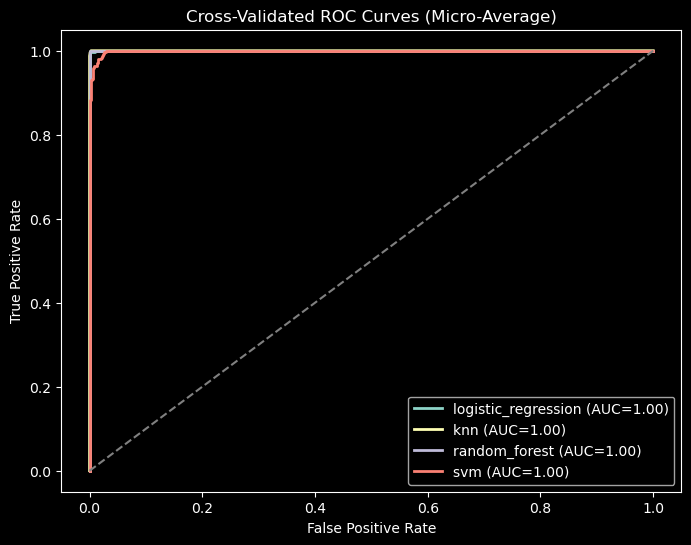

In [49]:
# ROC Curve

classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

fig, ax = plt.subplots(figsize=(8, 6))

for name, y_prob in cv_probabilities.items():
    fpr, tpr, _ = roc_curve(
        y_bin.ravel(),
        y_prob.ravel()
    )
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        label=f"{name} (AUC={roc_auc:.2f})",
        linewidth=2
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
ax.set_title("Cross-Validated ROC Curves (Micro-Average)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()